In [14]:
import pandas as pd
import plotly.express as px
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_is_fitted

# Prepare Data

In [15]:
def wrangle(filepath):
    # Read file into df
    df = pd.read_csv(filepath)
    mask = (df["TURNFEAR"] == 1) & (df["NETWORTH"] < 2e6)
    df = df[mask]
    return df

In [16]:
df = wrangle(r"C:\Users\hp\WorldQuantum\US-Segmentaion\US-Seg1.csv")

print("df type:", type(df))
print("df shape:", df.shape)

df.head()

df type: <class 'pandas.core.frame.DataFrame'>
df shape: (4418, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
5,2,21,3790.476607,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
6,2,22,3798.868505,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,3,2,2
7,2,23,3799.468393,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
8,2,24,3788.076005,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
9,2,25,3793.066589,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2


# Explore

## Calculate Variance

In [17]:
# Calculate variance, get 10 largest features
top_ten_var = df.var().sort_values().tail(10)

print("top_ten_var type:", type(top_ten_var))
print("top_ten_var shape:", top_ten_var.shape)
top_ten_var

top_ten_var type: <class 'pandas.core.series.Series'>
top_ten_var shape: (10,)


PLOAN1      1.140894e+10
ACTBUS      1.251892e+10
BUS         1.256643e+10
KGTOTAL     1.346475e+10
DEBT        1.848252e+10
NHNFIN      2.254163e+10
HOUSES      2.388459e+10
NETWORTH    4.847029e+10
NFIN        5.713939e+10
ASSET       8.303967e+10
dtype: float64

## Plot Variance

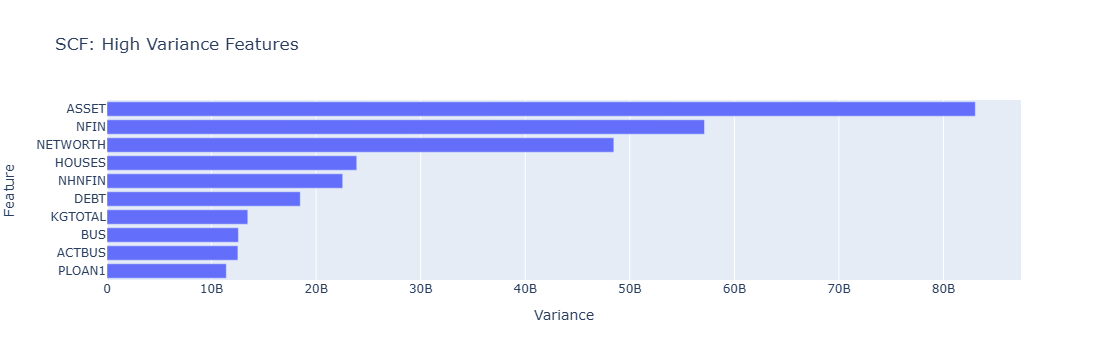

In [18]:
# Create horizontal bar chart of `top_ten_var`
fig = px.bar(
    x=top_ten_var,
    y=top_ten_var.index,
    title="SCF: High Variance Features"
)
fig.update_layout(xaxis_title="Variance", yaxis_title="Feature")
fig.show()

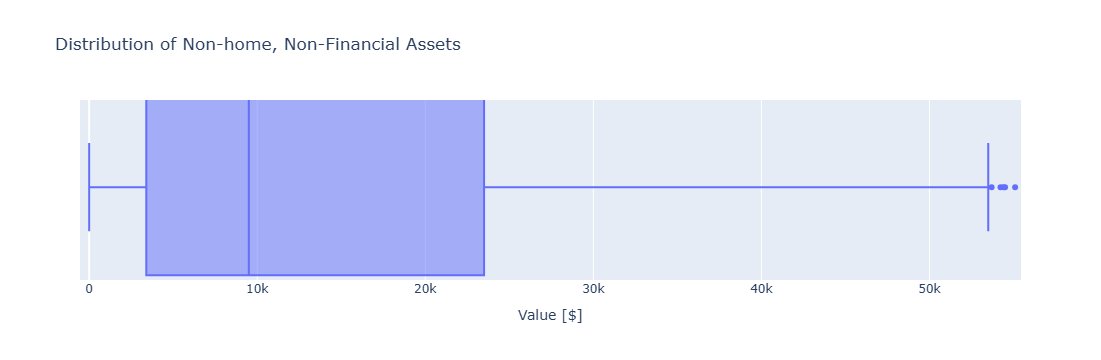

In [19]:
# Create a boxplot of `NHNFIN`
fig = px.box(
    data_frame=df,
    x="NHNFIN",
    title = "Distribution of Non-home, Non-Financial Assets"
)
fig.update_layout(xaxis_title="Value [$]")
fig.show()

### Whoa! The dataset is massively right-skewed because of the huge outliers on the right side of the distribution. Even though we already excluded households with a high net worth with our wrangle function, the variance is still being distorted by some extreme outliers.

### The best way to deal with this is to look at the trimmed variance, where we remove extreme values before calculating variance. We can do this using the trimmed_variance function from the SciPy library.

## Trimmed Variance

In [20]:
# Calculate trimmed variance
top_ten_trim_var = df.apply(trimmed_var, limits=(0.1, 0.1)).sort_values().tail(10)

print("top_ten_trim_var type:", type(top_ten_trim_var))
print("top_ten_trim_var shape:", top_ten_trim_var.shape)
top_ten_trim_var

top_ten_trim_var type: <class 'pandas.core.series.Series'>
top_ten_trim_var shape: (10,)


WAGEINC     5.550737e+08
HOMEEQ      7.338377e+08
NH_MORT     1.333125e+09
MRTHEL      1.380468e+09
PLOAN1      1.441968e+09
DEBT        3.089865e+09
NETWORTH    3.099929e+09
HOUSES      4.978660e+09
NFIN        8.456442e+09
ASSET       1.175370e+10
dtype: float64

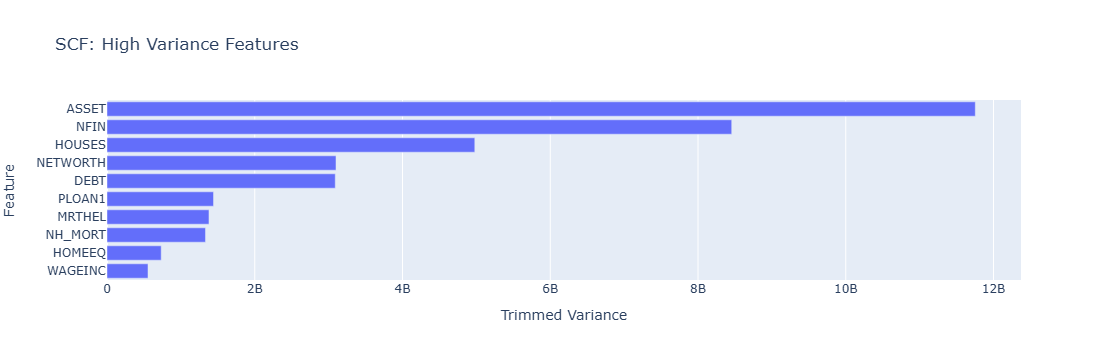

In [21]:
# Create horizontal bar chart of `top_ten_trim_var`
fig = px.bar(
    x=top_ten_trim_var,
    y=top_ten_trim_var.index,
    title="SCF: High Variance Features"
)
fig.update_layout(xaxis_title="Trimmed Variance", yaxis_title="Feature")
fig.show()

In [22]:
top_ten_trim_var.tail(5).index

Index(['DEBT', 'NETWORTH', 'HOUSES', 'NFIN', 'ASSET'], dtype='object')

In [23]:
high_var_cols = top_ten_trim_var.tail(5).index
print("high_var_cols type:", type(high_var_cols))
print("high_var_cols len:", len(top_ten_trim_var))
high_var_cols

high_var_cols type: <class 'pandas.core.indexes.base.Index'>
high_var_cols len: 10


Index(['DEBT', 'NETWORTH', 'HOUSES', 'NFIN', 'ASSET'], dtype='object')

# Split

In [24]:
X = df[high_var_cols]
print("X type:", type(X))
print("X shape:", X.shape)
X.head()

X type: <class 'pandas.core.frame.DataFrame'>
X shape: (4418, 5)


,DEBT,NETWORTH,HOUSES,NFIN,ASSET
5,12200.0,-6710.0,0.0,3900.0,5490.0
6,12600.0,-4710.0,0.0,6300.0,7890.0
7,15300.0,-8115.0,0.0,5600.0,7185.0
8,14100.0,-2510.0,0.0,10000.0,11590.0
9,15400.0,-5715.0,0.0,8100.0,9685.0


# Build Model

During our EDA, we saw that we had a scale issue among our features. That issue can make it harder to cluster the data, so we'll need to fix that to help our analysis along. One strategy we can use is standardization, a statistical method for putting all the variables in a dataset on the same scale. Let's explore how that works here. Later, we'll incorporate it into our model pipeline.

In [25]:
X_summary = X.aggregate(["mean", "std"]).astype(int)

print("X_summary type:", type(X_summary))
print("X_summary shape:", X_summary.shape)
X_summary

X_summary type: <class 'pandas.core.frame.DataFrame'>
X_summary shape: (2, 5)


,DEBT,NETWORTH,HOUSES,NFIN,ASSET
mean,72701,76387,74530,117330,149089
std,135950,220159,154546,239038,288166


## Standardization

In [26]:
x = X["DEBT"]
print("mean", round(x.mean()))
print("std:", round(x.std()))

mean 72701
std: 135950


In [27]:
x_scaled = (x-x.mean()) / x.std()
print("mean", round(x_scaled.mean()))
print("std:", round(x_scaled.std()))

mean 0
std: 1


In [28]:
# Instantiate transformer
ss = StandardScaler()

# Transform `X`
X_scaled_data = ss.fit_transform(X)

# Put `X_scaled_data` into DataFrame
X_scaled = pd.DataFrame(X_scaled_data, columns=X.columns)

print("X_scaled type:", type(X_scaled))
print("X_scaled shape:", X_scaled.shape)
X_scaled.head()

X_scaled type: <class 'pandas.core.frame.DataFrame'>
X_scaled shape: (4418, 5)


,DEBT,NETWORTH,HOUSES,NFIN,ASSET
0,-0.445075,-0.377486,-0.48231,-0.474583,-0.498377
1,-0.442132,-0.368401,-0.48231,-0.464541,-0.490047
2,-0.422270,-0.383868,-0.48231,-0.467470,-0.492494
3,-0.431097,-0.358407,-0.48231,-0.449061,-0.477206
4,-0.421534,-0.372966,-0.48231,-0.457010,-0.483818


### As you can see, all five of the features use the same scale now. But just to make sure, let's take a look at their mean and standard deviation.

In [30]:
X_scaled_summary = X_scaled.aggregate(["mean", "std"]).astype(int)

print("X_scaled_summary type:", type(X_scaled_summary))
print("X_scaled_summary shape:", X_scaled_summary.shape)
X_scaled_summary

X_scaled_summary type: <class 'pandas.core.frame.DataFrame'>
X_scaled_summary shape: (2, 5)


,DEBT,NETWORTH,HOUSES,NFIN,ASSET
mean,0,0,0,0,0
std,1,1,1,1,1


## Now that we can compare all our data on the same scale, we can start making clusters. We need to figure out how many clusters we should have.

In [31]:
n_clusters = range(2, 13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    #Build model
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    #Train model
    model.fit(X)
    #Calculate inertia
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    # Calculatee silhouette score
    silhouette_scores.append(
        silhouette_score(X, model.named_steps["kmeans"].labels_)
    )
        
print("inertia_errors type:", type(inertia_errors))
print("inertia_errors len:", len(inertia_errors))
print("Inertia:", inertia_errors)
print()
print("silhouette_scores type:", type(silhouette_scores))
print("silhouette_scores len:", len(silhouette_scores))
print("Silhouette Scores:", silhouette_scores)

inertia_errors type: <class 'list'>
inertia_errors len: 11
Inertia: [11028.058082607182, 7190.703769068731, 6233.106346879304, 5009.68391018874, 4935.578599045226, 4282.331488864092, 4103.6585674171965, 3503.1098972163227, 2874.961491201998, 2646.0943941378823, 2505.4713082029]

silhouette_scores type: <class 'list'>
silhouette_scores len: 11
Silhouette Scores: [0.7464502937083215, 0.7042841259119152, 0.7046977054481021, 0.6563064140490201, 0.6589817231149715, 0.6414988659227319, 0.6423235394675234, 0.6453132882450023, 0.6392046929708322, 0.6214410819897591, 0.6237975162108229]


## Let's create an elbow plot to see how many clusters we should use.
## Plot Inertia Vs. Clusters

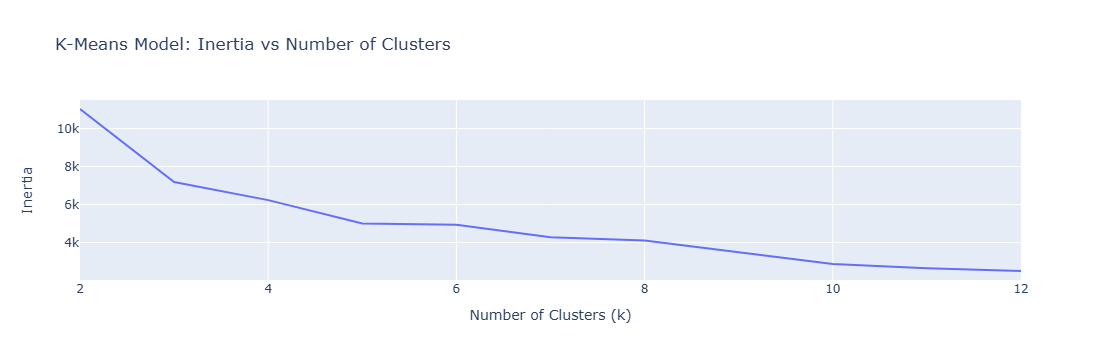

In [32]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
    x=n_clusters, y=inertia_errors, title="K-Means Model: Inertia vs Number of Clusters"
)
fig.update_layout(xaxis_title="Number of Clusters (k)", yaxis_title="Inertia")
fig.show()

## Plot Silhouette Score Vs. Clusters

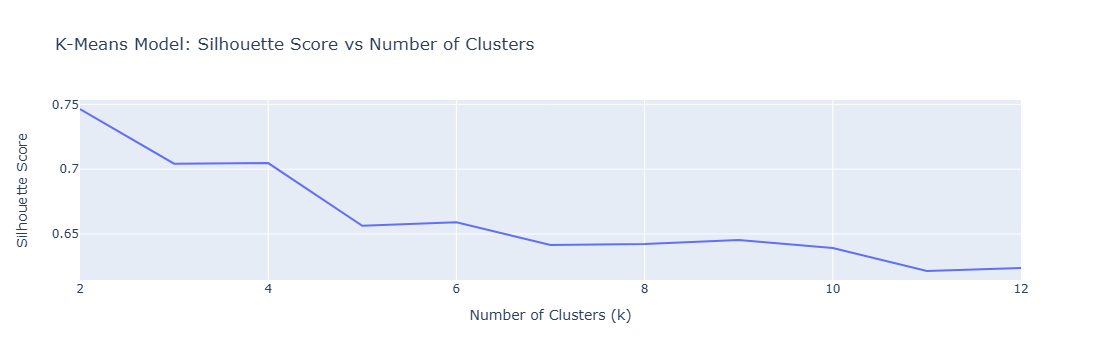

In [34]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(
    x=n_clusters, 
    y=silhouette_scores, 
    title="K-Means Model: Silhouette Score vs Number of Clusters"
)
fig.update_layout(xaxis_title="Number of Clusters (k)", yaxis_title="Silhouette Score")
fig.show()

## Build Final Model

In [35]:
# Build model
final_model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=4, random_state=42)
)

# Fit model to data
final_model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

# Communicate

### Extract Labels

In [36]:
labels = final_model.named_steps["kmeans"].labels_

print("labels type:", type(labels))
print("labels len:", len(labels))
print(labels[:5])

labels type: <class 'numpy.ndarray'>
labels len: 4418
[1 1 1 1 1]


### Side by side Bar Chart: Get Centroids

In [37]:
xgb = X.groupby(labels).mean()

print("xgb type:", type(xgb))
print("xgb shape:", xgb.shape)
xgb

xgb type: <class 'pandas.core.frame.DataFrame'>
xgb shape: (4, 5)


,DEBT,NETWORTH,HOUSES,NFIN,ASSET
0,205111.440049,2.314333e+05,261927.688504,3.512653e+05,4.365447e+05
1,28650.810927,1.176536e+04,14647.482838,2.825256e+04,4.041617e+04
2,669360.967742,5.819507e+05,788306.451613,1.118355e+06,1.251312e+06
3,266576.274510,1.432137e+06,339117.647059,1.295769e+06,1.698713e+06


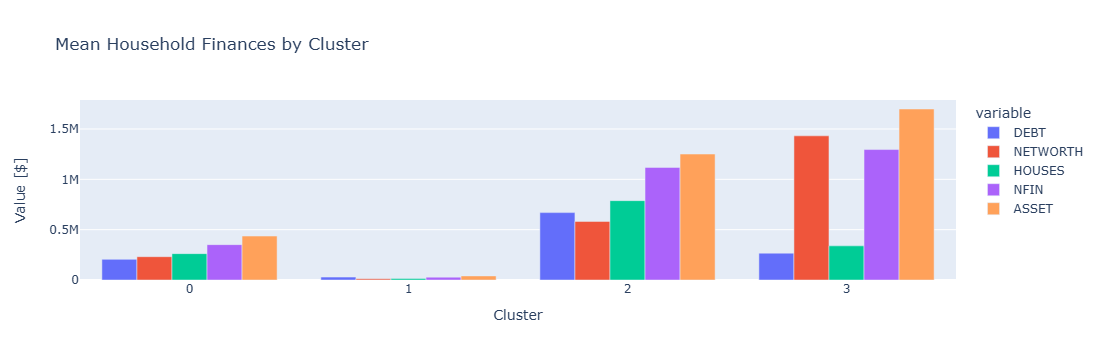

In [38]:
# Create side-by-side bar chart of `xgb`
fig = px.bar(
    xgb,
    barmode="group",
    title="Mean Household Finances by Cluster"
)

fig.update_layout(xaxis_title="Cluster", yaxis_title="Value [$]")

fig.show()

### PCA is bysicle and it looses explainability....

In [39]:
# Instantiate transformer
pca = PCA(n_components=2, random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=["PC1", "PC2"])

print("X_pca type:", type(X_pca))
print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca type: <class 'pandas.core.frame.DataFrame'>
X_pca shape: (4418, 2)


,PC1,PC2
0,-221525.424530,22052.273003
1,-217775.100722,22851.358068
2,-219519.642175,19023.646333
3,-212195.720367,22957.107039
4,-215540.507551,20259.749306


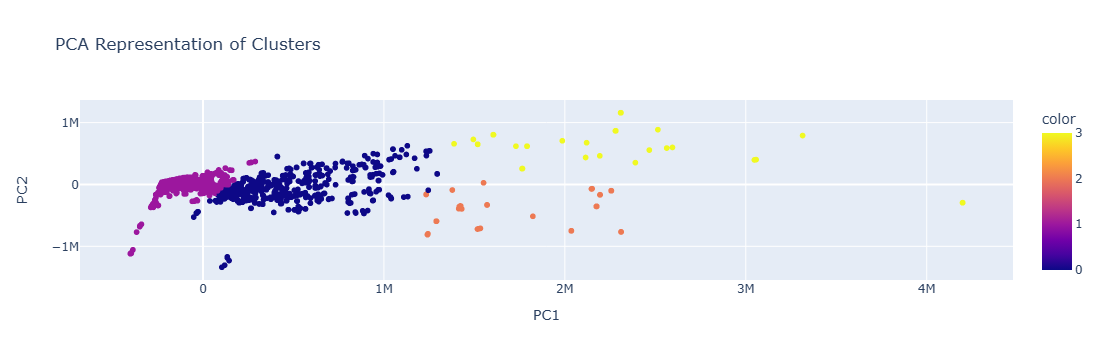

In [40]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(
    data_frame=X_pca,
    x="PC1",
    y="PC2",
    color=labels,
    title="PCA Representation of Clusters"
)
fig.update_layout(xaxis_title="PC1", yaxis_title="PC2")
fig.show()